In [1]:
import pandas as pd
import requests
import json
import numpy as np
import seaborn as sns


In [2]:
from datetime import datetime

print(f"Last time this notebook runs at {datetime.now():%d %h, %Y %H:%M:%S}.")

Last time this notebook runs at 03 Mar, 2023 09:58:42.


# Get reponse from `URL`


In [3]:
url = 'https://learn.pwskills.com/_next/data/Ags5MBEe764gpjeSLm3-n/course/Data-Science-masters/63a2eb428899436daf7eb489.json'

# New data id on 26 Feb
url = 'https://learn.pwskills.com/_next/data/vy3oIZoqr3YCpkH5886xy/course/Data-Science-masters/63a2eb428899436daf7eb489.json'

r = requests.get(url)
r

<Response [200]>

## Get Course ID

In [4]:
def get_course_id(url: str): return url.split('/')[-1].split('.')[0]

course_id = get_course_id(url)
course_id

'63a2eb428899436daf7eb489'

## Get the JSON data.

If the response's **status code** is `200`. Otherwise, import the stored JSON file `'../data/{course_id}.json'`.


In [5]:
if r.status_code == 200:
    live_course = r.json()
else:
    live_course = json.load(open(f'../data/{course_id}.json'))

## Export the JSON data when response status code is 200.


In [6]:
if r.status_code == 200:
    json.dump(r.json(), open(f'../data/courses/{course_id}.json', 'w'), indent=2)

In [7]:
# sections data
live_course_section = live_course['pageProps']['sections']['sections']

# lessons data
live_course_lessons = live_course['pageProps']['sections']['lessonDetails']

# Import `sections` data


In [8]:
sections = pd.json_normalize(live_course_section, 'lessons', 'title')
print(sections.shape)
sections.head()

(150, 2)


,0,title
0,63d41cbf0e5fcb4eda852ad7,Feedback Form
1,63d18b200e5fcb8d9484ecd9,Ask your Doubt Form
2,63d76e9f0e5fcb52fa85914b,Live Doubt Clearing Session Monday & Saturday ...
3,63d8b0e30e5fcbf81a85bb12,Doubt Clearing Recording
4,63ded727194b22529ee3e690,Doubt Clearing Recording


### Extract `dates` from `title`


In [9]:
sections['date'] = (sections['title']
                    .str.extract(r"(\d{1,2}\w{0,2} \w{3}'23)")
                    .astype('datetime64'))

### Remove `dates` from `title`


In [10]:
sections['title'] = (sections['title']
                     .str.replace(r"(\d{1,2}\w{0,2} \w{3}'23)", '', regex=True)
                     .str.strip())

### Rename columns


In [11]:
sections.rename(columns={0: '_id', 'title': 'sectionsTitle'}, inplace=True)

In [12]:
sections.head()

,_id,sectionsTitle,date
0,63d41cbf0e5fcb4eda852ad7,Feedback Form,NaT
1,63d18b200e5fcb8d9484ecd9,Ask your Doubt Form,NaT
2,63d76e9f0e5fcb52fa85914b,Live Doubt Clearing Session Monday & Saturday ...,NaT
3,63d8b0e30e5fcbf81a85bb12,Doubt Clearing Recording,NaT
4,63ded727194b22529ee3e690,Doubt Clearing Recording,NaT


# Import `lessons` data


In [13]:
lessons = pd.DataFrame.from_dict(live_course_lessons)
lessons.head()

,_id,data,title,type,quizQuestions,totalQuestionsInQuiz
0,63a83107816f9c3772c01074,{'thumbnail': 'https://i.ytimg.com/vi/aMsADXah...,Course Induction,video,[],NaN
1,63b6b091334640cb47715bf1,{'thumbnail': 'https://i.ytimg.com/vi/jIzBX3ei...,Course Overview And Dashboard Description,video,[],NaN
2,63b6b0a93346406567715bf9,{'thumbnail': 'https://i.ytimg.com/vi/JUm-e2Rp...,Lab Introduction,video,[],NaN
3,63b6b0bd3346407016715c01,{'thumbnail': 'https://i.ytimg.com/vi/lMjJkKTr...,Experience Portal Introduction,video,[],NaN
4,63b6b0d833464091f0715c09,{'thumbnail': 'https://i.ytimg.com/vi/9jg375lK...,Let's Get Started,video,[],NaN


### Extract video `duration` from `data` column.

In [14]:
lessons['duration'] = lessons['data'].str.get('duration')  # type: ignore

### Extract assignments `maxPoints` from `data` column.

In [15]:
lessons['totalPointsInAssignment'] = lessons['data'].str.get('maxPoints')  # type: ignore

### Extract sectionResource's `resourceURl` from `data` column.

In [16]:
lessons['url'] = lessons['data'].str.get('resourceURL')  # type: ignore

In [17]:
lessons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      150 non-null    object 
 1   data                     121 non-null    object 
 2   title                    150 non-null    object 
 3   type                     150 non-null    object 
 4   quizQuestions            121 non-null    object 
 5   totalQuestionsInQuiz     29 non-null     float64
 6   duration                 69 non-null     float64
 7   totalPointsInAssignment  26 non-null     float64
 8   url                      25 non-null     object 
dtypes: float64(3), object(6)
memory usage: 10.7+ KB


### Check `quizQuestions` column


In [18]:
no_of_na_vals = (lessons['quizQuestions']
                 .apply(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x)
                 .isnull().sum())

print(f"'quizQuestions' columns has {no_of_na_vals} null values out of {lessons.shape[0]} values.")
print('Thats why, need to drop it.')

'quizQuestions' columns has 150 null values out of 150 values.
Thats why, need to drop it.


### Drop Columns


In [19]:
lessons.drop(columns=['data', 'quizQuestions'], inplace=True)

### Rename columns


In [20]:
# Rename the title column to differentiate
lessons.rename(columns={
    'title': 'lessonsTitle'
}, inplace=True)

In [21]:
lessons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      150 non-null    object 
 1   lessonsTitle             150 non-null    object 
 2   type                     150 non-null    object 
 3   totalQuestionsInQuiz     29 non-null     float64
 4   duration                 69 non-null     float64
 5   totalPointsInAssignment  26 non-null     float64
 6   url                      25 non-null     object 
dtypes: float64(3), object(4)
memory usage: 8.3+ KB


# Merge the datasets


In [22]:
df = sections.merge(lessons, on='_id', how='inner')
print(df.shape)
df.head()

(150, 9)


,_id,sectionsTitle,date,lessonsTitle,type,totalQuestionsInQuiz,duration,totalPointsInAssignment,url
0,63d41cbf0e5fcb4eda852ad7,Feedback Form,NaT,Feedback Form,sectionResource,NaN,NaN,NaN,https://forms.gle/ffQcthJddQGBjofD8
1,63d18b200e5fcb8d9484ecd9,Ask your Doubt Form,NaT,Ask your doubt,sectionResource,NaN,NaN,NaN,https://forms.gle/1kj81RHPS4ErGjGV9
2,63d76e9f0e5fcb52fa85914b,Live Doubt Clearing Session Monday & Saturday ...,NaT,Live Doubt Clearing Session Monday & Saturday ...,sectionResource,NaN,NaN,NaN,https://us06web.zoom.us/j/86960400780
3,63d8b0e30e5fcbf81a85bb12,Doubt Clearing Recording,NaT,30th Jan Doubt Clearing Session,video,NaN,11107.0,NaN,None
4,63ded727194b22529ee3e690,Doubt Clearing Recording,NaT,4th Feb Doubt Session,video,NaN,NaN,NaN,None


# EDA ON DATA

### Count of different `type` in course


In [23]:
df['type'].value_counts()

video              70
quiz               29
assignment         26
sectionResource    25
Name: type, dtype: int64

In [24]:
# In percentage
df['type'].value_counts(True).mul(100).round(1)

video              46.7
quiz               19.3
assignment         17.3
sectionResource    16.7
Name: type, dtype: float64

<AxesSubplot: xlabel='type', ylabel='count'>

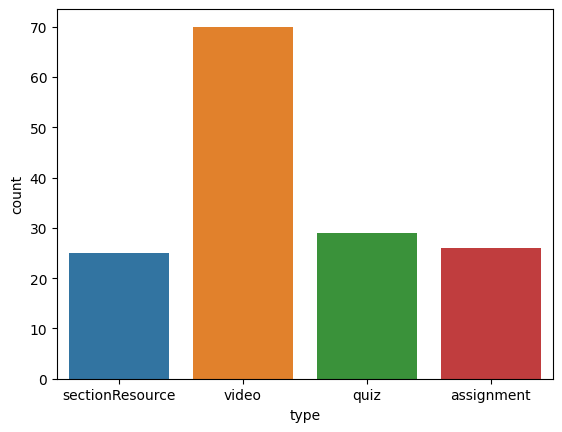

In [25]:
# In countplot
sns.countplot(data=df, x='type')

### What is _sectionResource_?

Initially, `sectionResource` contains the `resourceURL` for __Live classes, Doubt classes and Feedback form__.  
But now, on **2 March, 2023** new `sectionResource` is added to the course as **Python Practice** and it contains the G-Drive URL of PDFs and Docs.

In [42]:
sec_resource = df.query("type=='sectionResource'")

print(sec_resource.shape)
sec_resource.tail()

(25, 9)


,_id,sectionsTitle,date,lessonsTitle,type,totalQuestionsInQuiz,duration,totalPointsInAssignment,url
145,6400d0e8182c67d48c4c0ab0,Python Practice Solutions,NaT,Python Practice Set-7,sectionResource,NaN,NaN,NaN,https://drive.google.com/file/d/1C2-87zdD6K5Ju...
146,6400d10f182c6742194c0ab5,Python Practice Solutions,NaT,Python Practice Set-8,sectionResource,NaN,NaN,NaN,https://drive.google.com/file/d/18X7DcoTLYy3eE...
147,6400d133182c6769534c0aba,Python Practice Solutions,NaT,Python Practice Set-9,sectionResource,NaN,NaN,NaN,https://drive.google.com/file/d/1XELLrb2N_NSql...
148,6400d163182c673a334c0abf,Python Practice Solutions,NaT,Python Practice Set-10,sectionResource,NaN,NaN,NaN,https://docs.google.com/document/d/1uGQa0_EcRx...
149,6400d186182c6752ca4c0afa,Python Practice Solutions,NaT,Python Practice Set-11,sectionResource,NaN,NaN,NaN,https://docs.google.com/document/d/10hbDkw5V1i...


### Live Course Duration

In [27]:
total_quiz_ques = df['totalQuestionsInQuiz'].sum()
total_asgn_points = df['totalPointsInAssignment'].sum()
total_video_duration = round(df['duration'].sum() / 3600, 2)

In [28]:
print(f'No. of questions in Quiz = {int(total_quiz_ques)} questions.')
print(f'Total assignments points = {int(total_asgn_points)} points.')
print(f'Total duration of videos in Course = {total_video_duration} hours.')

No. of questions in Quiz = 228 questions.
Total assignments points = 2760 points.
Total duration of videos in Course = 65.83 hours.


### How many days has this course lasted so far?


In [29]:
max_date = df['date'].max()
min_date = df['date'].min()

print(f'For now the course has runs for {(max_date-min_date).days} days.')

For now the course has runs for 33 days.


In [30]:
print(f"First update in course on {min_date:%d %h, %Y}.")
print(f"Last update in course on {max_date:%d %h, %Y}.")

First update in course on 28 Jan, 2023.
Last update in course on 02 Mar, 2023.


### Most recent course Section and Lesson.

In [31]:
most_recent_section = df.query('date==@max_date')['sectionsTitle'].values[0]
most_recent_lesson = df.query('date==@max_date')['lessonsTitle'].values

In [32]:
print(f"Most recent course Section covered is {most_recent_section}.")
print(f"Most recent course Lesson covered are {', '.join(most_recent_lesson)}.")

Most recent course Section covered is Visualization.
Most recent course Lesson covered are Matplotlib, Matplotlib Assignment, Visualization quiz.


### No. of Sections and Lessons covered

In [33]:
no_of_sections = df['sectionsTitle'].nunique()
no_of_lessons = df['lessonsTitle'].nunique()

print(f"Till now, {no_of_sections} Sections covered in the course.")
print(f"And, {no_of_lessons} Lessons.")

Till now, 36 Sections covered in the course.
And, 143 Lessons.


# Make URLs

> Sample URL for videos: `https://api.pwskills.com/v1/learn/lesson/video-session/63a2eb428899436daf7eb489/lesson/63fa15eb182c67f36e4b90dd`

> Sample URL for Quiz and Assignment: `https://api.pwskills.com/v1/learn/lesson/course/63a2eb428899436daf7eb489/63fa2330182c6727c14b9189`


### Videos

In [34]:
# Base URL for videos
base_vid_url = f'https://api.pwskills.com/v1/learn/lesson/video-session/{course_id}/lesson/'

In [35]:
videos = df.query('type=="video"')

df.loc[videos.index, 'url'] = base_vid_url + videos['_id']

### Quiz and Assignments

In [37]:
# Base URL for Quiz and Assignments
base_url = f'https://api.pwskills.com/v1/learn/lesson/course/{course_id}/'

In [38]:
quizes = df.query('type=="quiz"')

df.loc[quizes.index, 'url'] = base_url + quizes['_id']

In [39]:
# Assignment url
assignmets = df.query('type=="assignment"')

df.loc[assignmets.index, 'url'] = base_url + assignmets['_id']

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   _id                      150 non-null    object        
 1   sectionsTitle            150 non-null    object        
 2   date                     104 non-null    datetime64[ns]
 3   lessonsTitle             150 non-null    object        
 4   type                     150 non-null    object        
 5   totalQuestionsInQuiz     29 non-null     float64       
 6   duration                 69 non-null     float64       
 7   totalPointsInAssignment  26 non-null     float64       
 8   url                      150 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 15.8+ KB


# Export the dataset as CSV

In [45]:
df.to_csv(f'../data/{course_id}.csv', index=False)